# 3 Edge detection

At its core, an **edge** in an image represents a boundary or significant change in intensity between adjacent pixels. This change could be in terms of color, brightness, or texture. Essentially, edges help define the shape and structure of objects within an image, making them one of the most fundamental features for understanding and interpreting visual data. The process in which the edges in an image are identified is called **edge detection**. By detecting objects we can, for example:

- **Identify objects:** Edges often correspond to the outlines of objects. For example, detecting the edge of a person against a background is crucial for tasks like object detection or segmentation.
- **Simplify images:** By focusing on the edges, we reduce an image to its most important structures. This simplification is useful in tasks like image compression or recognition.
- **Analyze shapes:** Many shape-based analyses depend on extracting edges to define boundaries. In gesture recognition, for instance, the edges of hands can be used to identify specific movements.

As commented, edges can be defined as transitions between image regions that have different gray levels (intensities). In this way, the unidimensional, continuous model of an ideal edge is:

<center><img src="./images/model_of_ideal_edge.PNG" width="600"></center>

That is, and edge is defined by three parameters: 
- **Intensity increment** ($H = A - B$): The difference in intensity between the bright and dark regions.
- **Slope angle** ($\alpha$): The angle of the transition, which represents how quickly the intensity changes from the dark region to the bright region. A steeper slope indicates a sharper edge, while a gradual slope suggests a softer transition (e.g., shadows or blurred boundaries).
- **Midpoint** ($x_0$): The location of the center of the edge, where the intensity transition is most prominent.


However, the idealized concept of an edge represented as this a continuous model doesn't fully capture the complexity found in discrete digital images, which are subject to noise and resolution limitations.



### Error types related to edge detection

Finding edges properly is not a straightforward task, as there exist different errors that can appear when applying edge detection techniques:
- **Detection error.** A good detector exhibits a low ratio of false negative and false positive, that is:
  - False negatives: Existing edges that are not detected.
  - False positives: Detected objects that are not real.
- **Localization error.** Edges are detected, but they are not at the real, exact position.
- **Multiple response.** Multiple detections are raised for the same edge (the edge is thick).

The following figure illustrates such errors.

<center><img src="./images/edge_errors.jpg" width="400"></center>

Thereby, when designing a good edge detector, the goal is to achieve low detection and localization errors, as well as to avoid multiple responses. 

# 3.1 Operators based on first derivative (gradient)

In the upcoming chapters, we are going to investigate and implement different edge detection methods. All of them are based on our dear convolution operation, having their own pros and cons.

Concretely, in this notebook we will cover **first-derivative** based operators, which try to detect borders by looking at abrupt intensity differences in neighbor pixels. In the image below we can see two functions $f(x)$ (first row) and how their derivatives (second row) reach their maximum values at the points where the functions' values change more abruptly (around $x_o$). 

<center><img src="./images/first_derivative_of_continuous_function.PNG" width="500">$\\[10pt]$</center>

If we are dealing with a **two-dimensional** continuous function $f(x,y)$, its derivative is a *vector* (**gradient**) defined as:$\\[10pt]$
$$
\nabla  f(x,y) = 
\begin{bmatrix} 
\frac{\partial}{\partial x}f(x,y) \\ \frac{\partial}{\partial y}f(x,y) 
\end{bmatrix} 
=
\begin{bmatrix}
f_x(x,y) \\
f_y(x,y)
\end{bmatrix}
$$

which points at the *direction* of maximum (positive) variation of $f(x,y)$:$\\[10pt]$

$$
\alpha(x,y) = \arctan \left(\frac{f_y(x,y)}{f_x(x,y)}\right)
$$

and has a *module* proportional to the strength of this variation:$\\[10pt]$

$$
|\nabla  f(x,y)| = \sqrt{(f_x(x,y))^2 + (f_y(x,y))^2} \approx |f_x(x,y)| + |f_y(x,y)|
$$

The image below shows examples of gradient vectors:$\\[10pt]$

<center><img src="./images/gradient_examples.PNG" width="700">$\\[10pt]$</center>

Concretely, the techniques based on the first derivative explored here are:

- Discrete approximations of a **gradient operator** (Sobel, Prewitt, Roberts, etc., <a href="#311">Section 3.1.1</a>).
- The **Derivative of Gaussian** (DroG) operator (<a href="#312">Section 3.1.2</a>).

## Problem context - Edge detection for medical images

Edge detection in medical images is of capital importance for the diagnosis of different diseases (e.g., the detection of tumor cells) in human organs such as lungs and prostates, becoming an essential pre-processing step in medical image segmentation.

<center><img src="./images/hospital_clinico.jpg" width="400"><br /><br /></center>

In this context, *Hospital Clínico*, a very busy hospital in Málaga, is asking local engineering students to join their research team. They are looking for a person with knowledge in image processing and, in order to ensure it, they have published 3 medical images: `medical_1.jpg`, `medical_2.jpg` and `medical_3.jpg`. They have asked us to perform accurate edge detection in the three images, as well as to provide an explanation of how it has been made.

In [1]:
import numpy as np
from scipy import signal
import cv2
import matplotlib.pyplot as plt
import matplotlib
from ipywidgets import interactive, fixed, widgets
matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)

images_path = './images/'

To face this challenge, we are going to use plenty edge detection methods, which will be tested and compared in order to determine the best option.

### **<span style="color:green"><b><i>ASSIGNMENT 1: Taking a look at images</i></b></span>**

First, **display the provided images** to get an idea about what we are dealing with.

*Note: As most medical images does not provide color information, we are going to use border detection in grayscale images.*

*Tip: Different approaches can be followed for edge detection in color images, like converting to YCrCb color space (appendix 2), or detecting edges on each RGB channel.*

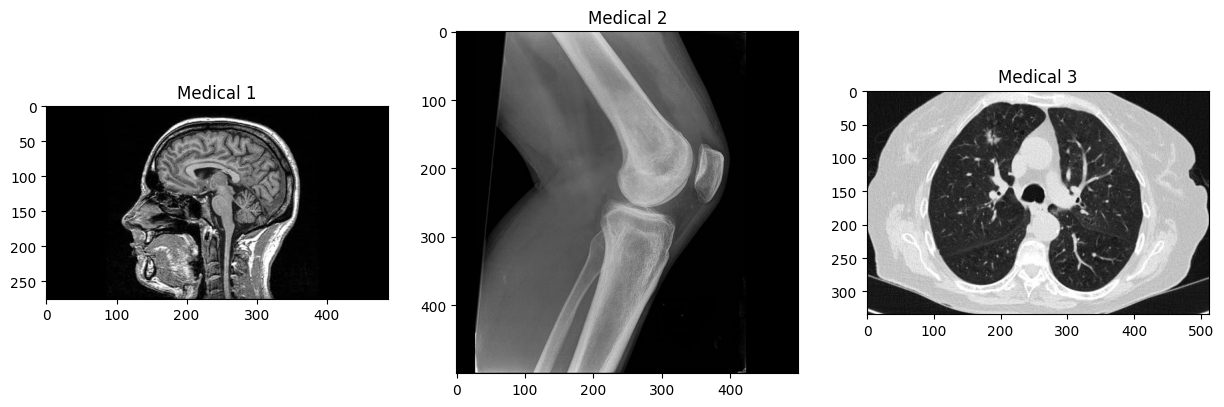

In [2]:
# ASSIGNMENT 1
# Display the provided images in a 1x3 plot to see what are we dealing with
# Write your code here!

# Read the images
medical_1 = cv2.imread(images_path + 'medical_1.jpg', 0)
medical_2 = cv2.imread(images_path + 'medical_2.jpg', 0)
medical_3 = cv2.imread(images_path + 'medical_3.jpg', 0)

# And show them
plt.subplot(131)
plt.imshow(medical_1, cmap='gray')
plt.title('Medical 1')

plt.subplot(132)
plt.imshow(medical_2, cmap='gray')
plt.title('Medical 2')

plt.subplot(133)
plt.imshow(medical_3, cmap='gray')
plt.title('Medical 3')
plt.show()

## 3.1.1 Discrete approximations of a gradient operator <a id=311></a>

The first bunch of methods that we are going to explore carry out a **discrete approximation of a gradient operator** based on the differences between gray (intensity) levels. For example, in order to obtain the derivative in the rows' direction, we could apply:

<div style="padding: 10px; margin: 0 auto; text-align: center; display: table;">

<div style = "padding: 0px; display: table-cell; vertical-align: middle; width: 370px; text-align:left;">- Backward difference of pixels along a row: <br /> $\, \, \, \,f_x(x,y) \approx G_R(i,j)=[F(i,j)-F(i-1,j)]/T$ </div>
    
<table style = "display: table-cell; vertical-align: middle;">
	<tbody>
		<tr>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">0</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;" bgcolor="#81F7F3">1</td>
			<td style="border: 1px solid;">-1</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">0</td>
		</tr>
	</tbody>
</table> 
    
</div>

<div style="padding: 10px; margin: 0 auto; text-align: center; display: table;">

<div style = "padding: 0px; display: table-cell; vertical-align: middle; width: 370px; text-align:left;">- Symmetric difference of pixels along a row: <br /> $\, \, \, \,f_x(x,y) \approx G_R(i,j)=[F(i+1,j)-F(i-1,j)]/2T$ </div>
    
<table style = "display: table-cell; vertical-align: middle;">
	<tbody>
		<tr>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">0</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">1</td>
			<td style="border: 1px solid;" bgcolor="#81F7F3">0</td>
			<td style="border: 1px solid;">-1</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">0</td>
		</tr>
	</tbody>
</table> 

</div>

These approximations are typically implemented through the convolution of the image with a pair of templates $H_R$ (for rows, computing horizontal derivatives for detecting vertical edges) and $H_C$ (for columns, computing vertical derivatives for detecting horizontal ones), that is:

$$
G_R(i,j) = F(i,j) \otimes H_R(i,j) \\
G_C(i,j) = F(i,j) \otimes H_C(i,j)
$$

Perhaps the most popular operator doing this is such of **Sobel**, although there are many of them that provide acceptable results. These operators use the aforementioned two kernels (typically of size $3\times3$ or $5\times5$) which are convolved with the original image to calculate approximations of the derivatives. 

These are some examples (first column: operator name; second one: $H_R$; third column: $H_C$):$\\[5pt]$

<div style="padding: 10px; margin: 0 auto; text-align: center;">

<div style = "padding: 0px; display: table-cell; vertical-align: middle; width: 70px; text-align:left;">Roberts</div>
    
<div style = "padding: 10px; display: table-cell; vertical-align: middle; width: 50px; text-align:right;"> </div>
    
<table style = "display: table-cell; vertical-align: middle;">
	<tbody>
		<tr>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">0</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;" bgcolor="#81F7F3">0</td>
			<td style="border: 1px solid;">1</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">-1</td>
			<td style="border: 1px solid;">0</td>
		</tr>
	</tbody>
</table>   
    
<div style = "padding: 10px; display: table-cell; vertical-align: middle; width: 50px; text-align:right;"> </div>
    
<table style = "display: table-cell; vertical-align: middle;">
	<tbody>
		<tr>
			<td style="border: 1px solid;">-1</td>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">0</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;" bgcolor="#81F7F3">1</td>
			<td style="border: 1px solid;">0</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">0</td>
		</tr>
	</tbody>
</table>  

</div>

<div style="padding: 10px; margin: 0 auto; text-align: center;">

<div style = "padding: 0px; display: table-cell; vertical-align: middle; width: 70px; text-align:left;">Prewitt</div>
    
<div style = "padding: 10px; display: table-cell; vertical-align: middle; width: 50px; text-align:right;">$\frac{1}{3}$ </div>
    
<table style = "display: table-cell; vertical-align: middle;">
	<tbody>
		<tr>
			<td style="border: 1px solid;">1</td>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">-1</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">1</td>
			<td style="border: 1px solid;" bgcolor="#81F7F3">0</td>
			<td style="border: 1px solid;">-1</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">1</td>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">-1</td>
		</tr>
	</tbody>
</table>   
    
<div style = "padding: 5px; display: table-cell; vertical-align: middle; width: 50px; text-align:right;">$\frac{1}{3}$ </div>
    
<table style = "display: table-cell; vertical-align: middle;">
	<tbody>
		<tr>
			<td style="border: 1px solid;">-1</td>
			<td style="border: 1px solid;">-1</td>
			<td style="border: 1px solid;">-1</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;" bgcolor="#81F7F3">0</td>
			<td style="border: 1px solid;">0</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">1</td>
			<td style="border: 1px solid;">1</td>
			<td style="border: 1px solid;">1</td>
		</tr>
	</tbody>
</table>  

</div>

<div style="padding: 10px; margin: 0 auto; text-align: center;">

<div style = "padding: 0px; display: table-cell; vertical-align: middle; width: 70px; text-align:left;">Sobel</div>
    
<div style = "padding: 10px; display: table-cell; vertical-align: middle; width: 50px; text-align:right;">$\frac{1}{4}$ </div>
    
<table style = "display: table-cell; vertical-align: middle;">
	<tbody>
		<tr>
			<td style="border: 1px solid;">1</td>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">-1</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">2</td>
			<td style="border: 1px solid;" bgcolor="#81F7F3">0</td>
			<td style="border: 1px solid;">-2</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">1</td>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">-1</td>
		</tr>
	</tbody>
</table>   
    
<div style = "padding: 5px; display: table-cell; vertical-align: middle; width: 50px; text-align:right;">$\frac{1}{4}$ </div>
    
<table style = "display: table-cell; vertical-align: middle;">
	<tbody>
		<tr>
			<td style="border: 1px solid;">-1</td>
			<td style="border: 1px solid;">-2</td>
			<td style="border: 1px solid;">-1</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;" bgcolor="#81F7F3">0</td>
			<td style="border: 1px solid;">0</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">1</td>
			<td style="border: 1px solid;">2</td>
			<td style="border: 1px solid;">1</td>
		</tr>
	</tbody>
</table>  

</div>

<div style="padding: 10px; margin: 0 auto; text-align: center;">

<div style = "padding: 0px; display: table-cell; vertical-align: middle; width: 70px; text-align:left;">Frei-Chen</div>
    
<div style = "padding: 10px; display: table-cell; vertical-align: middle; width: 70px; text-align:right;">$\frac{1}{2+\sqrt{2}}$ </div>
    
<table style = "display: table-cell; vertical-align: middle;">
	<tbody>
		<tr>
			<td style="border: 1px solid;">1</td>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">-1</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">&#x221A;2</td>
			<td style="border: 1px solid;" bgcolor="#81F7F3">0</td>
			<td style="border: 1px solid;">-&#x221A;2</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">1</td>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">-1</td>
		</tr>
	</tbody>
</table>   
    
<div style = "padding: 10px; display: table-cell; vertical-align: middle; width: 70px; text-align:right;">$\frac{1}{2+\sqrt{2}}$ </div>
    
<table style = "display: table-cell; vertical-align: middle;">
	<tbody>
		<tr>
			<td style="border: 1px solid;">-1</td>
			<td style="border: 1px solid;">-&#x221A;2</td>
			<td style="border: 1px solid;">-1</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;" bgcolor="#81F7F3">0</td>
			<td style="border: 1px solid;">0</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">1</td>
			<td style="border: 1px solid;">&#x221A;2</td>
			<td style="border: 1px solid;">1</td>
		</tr>
	</tbody>
</table>  

</div>

<div style="padding: 10px; margin: 0 auto; text-align: center;">

<div style = "padding: 0px; display: table-cell; vertical-align: middle; width: 70px; text-align:left;">In general</div>
    
<div style = "padding: 10px; display: table-cell; vertical-align: middle; width: 70px; text-align:right;">$\frac{1}{2+K}$ </div>
    
<table style = "display: table-cell; vertical-align: middle;">
	<tbody>
		<tr>
			<td style="border: 1px solid;">1</td>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">-1</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">K</td>
			<td style="border: 1px solid;" bgcolor="#81F7F3">0</td>
			<td style="border: 1px solid;">-K</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">1</td>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">-1</td>
		</tr>
	</tbody>
</table>   
    
<div style = "padding: 10px; display: table-cell; vertical-align: middle; width: 70px; text-align:right;">$\frac{1}{2+K}$ </div>
    
<table style = "display: table-cell; vertical-align: middle;">
	<tbody>
		<tr>
			<td style="border: 1px solid;">-1</td>
			<td style="border: 1px solid;">-K</td>
			<td style="border: 1px solid;">-1</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;" bgcolor="#81F7F3">0</td>
			<td style="border: 1px solid;">0</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">1</td>
			<td style="border: 1px solid;">K</td>
			<td style="border: 1px solid;">1</td>
		</tr>
	</tbody>
</table>  

</div>

At this point we know how to perform a discrete approximation of a gradient operator through the application of a convolution operation with two different kernels, that is:

$$\nabla  F(x,y) = 
\begin{bmatrix} 
F \otimes H_C \\ F \otimes H_R
\end{bmatrix}$$

But, how could we use the output of those computations to detect edges? The following figure clarifies that!

<center><img src="./images/how_to_detect_edges_with_gradient_image2.png" width="350"></center>

**Kernel sizes**

As discussed, kernels can be of different size, and that size directly affects the quality of the detection and the localization (e.g. Sobel $3\times3$ or $5\times5$):
- Small template:
  - more precise localization (good localization).
  - more affected by noise (likely produces false positives).
- Large template:
  - less precise localization.
  - more robust to noise (good detector).
  - higher computational cost ($O(N \times N)$).

### **<span style="color:green"><b><i>ASSIGNMENT 2: Playing with Sobel derivatives</i></b></span>**

Now that we have acquired a basic understanding of these methods, let's complete the following code cell to employ the Sobel kernels ($S_x,S_y$) to compute both derivatives and display them along with the original image (`medical_3.jpg`).

*Notice that the derivative image values can be positive **and negative**, caused by the negative values in the kernel. This implies that the desired depth of the destination image (`ddepth`) has to be at least a signed data type when calling to the `filter2D()` method.*

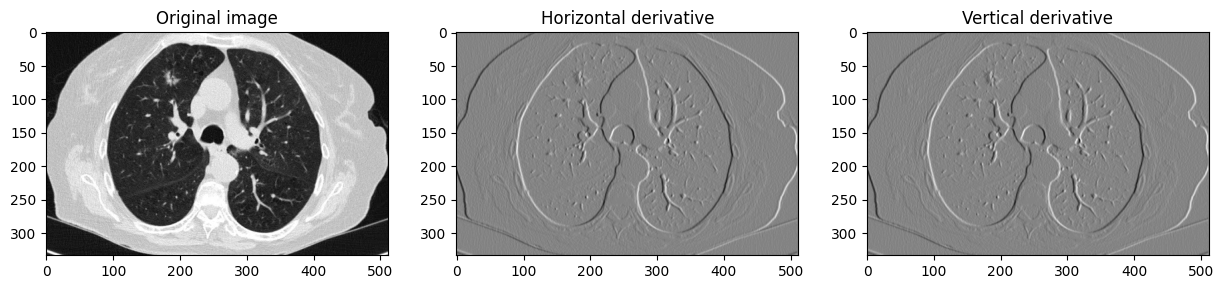

In [3]:
# ASSIGNMENT 2
# Read one of the images, compute both kernel derivatives, apply them to the image (separately) and display the original image and the derivatives in a 1x3 plot.
# Write your code here!

# Read the image
image = cv2.imread(images_path + 'medical_3.jpg', 0)

# Define horizontal and vertical kernels
kernel_h = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])*(1/4)
kernel_v = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])*(1/4)

# Apply convolution
d_horizontal = cv2.filter2D(image,cv2.CV_16S,kernel_h) # Using ddepth=cv2.CV_16S
d_vertical = cv2.filter2D(image,cv2.CV_16S,kernel_v)

# And show them!
plt.subplot(131)
plt.imshow(image, cmap='gray')
plt.title('Original image')

plt.subplot(132)
plt.imshow(d_horizontal, cmap='gray')
plt.title('Horizontal derivative')

plt.subplot(133)
plt.imshow(d_horizontal, cmap='gray')
plt.title('Vertical derivative');

Once we have computed both derivative images $G_C$ and $G_R$, we can determine the *complete* edge image by computing the image gradient magnitude and then binarizing the result. Recall that the image codifying the gradient magnitude can be computed and approximated as:

$$|\nabla F(x,y)| = \sqrt{(F \otimes G_C)^2 + (F \otimes G_R)^2} \approx |F \otimes G_C| + |F \otimes G_R|$$

### **<span style="color:green"><b><i>ASSIGNMENT 3a: Time to detect edges</i></b></span>**

Complete `edge_detection_chart()` that computes the gradient image of an input one using `kernel_h` and `kernel_v` (kernels for horizontal and vertical derivatives respectively) and **binarize the resultant image** (final edges image) using `threshold`. Then display in a 1x3 plot `image`, the gradient image, and finally, an image with the detected edges! (Only if `verbose` is True).

*Tip: you should [normalize](https://docs.opencv.org/2.4/modules/core/doc/operations_on_arrays.html#normalize) gradient image before thresholding.*

*Interesting functions: [`np.absolute()`](https://numpy.org/doc/stable/reference/generated/numpy.absolute.html), [`np.add()`](https://numpy.org/doc/stable/reference/generated/numpy.add.html), [`cv2.threshold()`](https://docs.opencv.org/master/d7/d1b/group__imgproc__misc.html#gae8a4a146d1ca78c626a53577199e9c57)*

In [4]:
# ASSIGNMENT 3a
# Implement a function that that computes the gradient of an image, taking also as input the convolution kernels.
# It must also binarize the resulting image using a threshold
# Show the input image, the gradient image (normalized) and the binarized edge image in a 1x3 plot (if verbose = True)
def edge_detection_chart(image, kernel_h, kernel_v, threshold, verbose=False):
    """ Computed the gradient of the image, binarizes and display it.   
    
        Args:
            image: Input image
            kernel_h: kernel for horizontal derivative
            kernel_v: kernel for vertical derivative
            threshold: threshold value for binarization
            verbose: Only show images if this is True
            
        Returns:
            edges: edges binary image
    """
    # Write your code here!
    
    # Compute derivatives
    d_h = cv2.filter2D(image,cv2.CV_16S,kernel_h) # horizontal
    d_v = cv2.filter2D(image,cv2.CV_16S,kernel_v) # vertical
    
    # Compute gradient
    gradient_image = np.add(np.absolute(d_h),np.absolute(d_v)) # Hint: You have to sum both derivatives in absolute value!
    
    #Normalize gradient
    norm_gradient = np.copy(image)
    norm_gradient = cv2.normalize(gradient_image, None, 0, 255, cv2.NORM_MINMAX)
    
    # Threshold to get edges
    ret, edges = cv2.threshold(norm_gradient, threshold, 255,cv2.THRESH_BINARY)
    
    if verbose:
        # Show the initial image
        plt.subplot(131)
        plt.imshow(image, cmap='gray')
        plt.title('Original image')

        # Show the gradient image
        plt.subplot(132)
        plt.imshow(gradient_image, cmap='gray')
        plt.title('Gradient image')

        # Show edges image
        plt.subplot(133)
        plt.imshow(edges, cmap='gray')
        plt.title('Edges detected')
    
    return edges

You can use next code to **test if your results are correct**:

In [5]:
image = np.array([[10,60,20],[60,22,74],[72,132,2]], dtype=np.uint8)

# Sobel derivatives
kernel_h = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])*1/4
kernel_v = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])*1/4

print(edge_detection_chart(image, kernel_h, kernel_v, 100))

[[  0   0   0]
 [255 255 255]
 [  0 255   0]]


<font color='blue'>**Expected output:**  </font>

    [[  0   0   0]
     [255 255 255]
     [  0 255   0]]

### **<span style="color:green"><b><i>ASSIGNMENT 3b: Testing our detector</i></b></span>**

Now **try the implemented method** with different size Sobel kernels ($3\times3$, $5\times5$, ...). $\\[5pt]$  

In [6]:
# ASSIGNMENT 3b
# Read the image, set you kernels (Sobel, Roberts, Prewitt, etc.) and interact with the threshold parameter.
# Write your code here!

# Read image
image = cv2.imread(images_path + 'medical_3.jpg', 0)

# Define kernel (Sobel)
kernel_h =  np.array([[-2, -1,  0,  1,  2],
                             [-2, -1,  0,  1,  2],
                             [-4, -2,  0,  2,  4],
                             [-2, -1,  0,  1,  2],
                             [-2, -1,  0,  1,  2]])
kernel_v = np.array([[-2, -2, -4, -2, -2],
                           [-1, -1, -2, -1, -1],
                           [ 0,  0,  0,  0,  0],
                           [ 1,  1,  2,  1,  1],
                           [ 2,  2,  4,  2,  2]])

kernel_h3x3 = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])*1/4
kernel_v3x3 = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])*1/4

prewitt_horizontal = np.array([[1, 0, -1],
                               [1, 0, -1],
                               [1, 0, -1]])*1/3

prewitt_vertical = np.array([[-1, -1, -1],
                             [ 0,  0,  0],
                             [ 1,  1,  1]])*1/3

roberts_horizontal = np.array([[0, 0, 0],
                               [0, 0, 1],
                               [0, -1, 0]])

roberts_vertical = np.array([[-1, 0, 0],
                               [0, 1,0],
                               [0, 0, 0]])


#Interact with your code!
interactive( edge_detection_chart, image=fixed(image), kernel_h=fixed(kernel_h), kernel_v=fixed(kernel_v), threshold=(0,255,10), verbose=fixed(True))

interactive(children=(IntSlider(value=120, description='threshold', max=255, step=10), Output()), _dom_classes…

### **<span style="color:green"><b><i>OPTIONAL</i></b></span>**

Try other edge detection operators based on the first derivative with different kernel sizes (Roberts, Prewitt, etc.).

### <font color="blue"><b><i>Thinking about it (1)</i></b></font>

Now, **answer following questions**:

- What happens if we use a bigger kernel?
  
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Se aprecia cómo se detectan mejor los bordes exteriores, pero en el interior se detectan mucho menos. Detecta mejor esos bordes y elimina ruido, pero a la vez es menos preciso</i></p>
    
- There are differences between Sobel and other operators?
  
    <p style="margin: 4px 0px 0px 5px; color:blue"><i>Sí, he probado con Prewitt y con Robert. La diferencia con Prewitt no es muy grande, pero con Robert sí. (profundizo en el siguiente apartado).</i></p>  
    
- What errors appear using those operators?

    <p style="margin: 4px 0px 0px 5px; color:blue"><i>Usando Prewitt, aparecía bastante más ruido, sin embargo, la detección Robert era bastante mala. Ruido por todos lados y los bordes muy mal definidos.</i></p>  
    
- Why kernels usually are divided by a number? (e.g. $3\times3$ Sobel is divided by 4)

    <p style="margin: 4px 0px 0px 5px; color:blue"><i>Para normalizar la escala, por ejemplo, evitando que se saturen los píxeles.</i></p>  

## 3.1.2 DroG operator <a id=312></a>

Despite the simplicity of the previous techniques, they have a remarkable drawback: their performance is highly influenced by image noise. Taking a look at the following figure we can see how, having an apparently not so noisy function (first row), where it is easy to visually detect a step (an abrupt change in its values) around 1000, the response of the derivative with that level of noise is as bigger as the step itself!$\\[5pt]$

<center><img src="./images/example_of_derivative_of_noisy_function.PNG" width="600"><br /></center>
<center><i>Source: S. Seitz</i></center>$\\[5pt]$

But not everything is lost! An already studied image processing technique can be used to mitigate such noise: **image smoothing**, and more concretely, **Gaussian filtering!** The basic idea is to smooth the image and then apply a gradient operator, that is to compute $\frac{\partial}{\partial x}(f \otimes g)$. Not only that, this can be done even more efficiently thanks to the convolution derivative property:$\\[5pt]$

$$\frac{\partial}{\partial x}(f \otimes g) = f \otimes \frac{\partial}{\partial x}g
$$$\\[5pt]$

That is, precomputing the resultant kernels from the convolution of the Gaussisan filtering and the Sobel ones, and then convolving them with the image to be processed. With that we save one operation!$\\[5pt]$

This combination of smoothing and gradient is usually called **Derivative of Gaussian operator (DroG)**. Formally:$\\[5pt]$

$$
\nabla [f(x,y)\otimes g_\sigma(x,y)] = 
f(x,y) \otimes \nabla [g_\sigma(x,y)] = 
f(x,y) \otimes \text{DroG} (x,y)
$$

$$
DroG(x,y) = 
\nabla \left[ g_\sigma (x,y) \right] = 
\underbrace{\begin{bmatrix} 
\frac{\partial}{\partial x}[g_\sigma(x)g_\sigma(y)] \\ 
\frac{\partial}{\partial y}[g_\sigma(x)g_\sigma(y)] \end{bmatrix}}_{\text{separability}} = 
\underbrace{\begin{bmatrix} \frac{-xg_\sigma(x)g_\sigma(y)}{\sigma^2} \\ \frac{-yg_\sigma(x)g_\sigma(y)}{\sigma^2}\end{bmatrix}}_{g(x)'=-xg(x)/\sigma^2} = 
\begin{bmatrix} \frac{-xg_\sigma(x,y)}{\sigma^2} \\ \frac{-yg_\sigma(x,y)}{\sigma^2}\end{bmatrix}
$$

Recall that $g_\sigma(x,y)$ is just the 2D gaussian kernel. We worked with it in Chapter 2! 

Also remember from the previous notebooks the expression of the Gaussian distribution with 2 variables centered at the origin of coordinates, where the standard deviation $\sigma$ controls the degree of smoothness: 

Remember from the previous notebooks the expression of the Gaussian distribution with 2 variables centered at the origin of coordinates, where the standard deviation $\sigma$ controls the degree of smoothness: 
 
$$g_{\sigma}(x,y) = \frac{1}{2\pi\sigma^2}exp\left(-\frac{x^2+y^2}{2\sigma^2}\right)$$

Take into account that the DroG template or kernel is **created just once**! Then it can applied to as many images as you want.

### **<span style="color:green"><b><i>ASSIGNMENT 4: Applying DroG</i></b></span>**

We would like to try this robust edge detection technique, so complete the `gaussian_kernel()` method that:

1. constructs a 2D gaussian filter (that is, $g_\sigma(x,y)$ in the previous DroG definition) from a 1D one, and 
2. derives it, getting the DroG template (in other words, compute $-x g_\sigma(x,y)/\sigma^2$ and $-y g_\sigma(x,y)/\sigma^2$). 
3. Finally, it calls our function `edge_detection_chart()`, but using the DroG template instead of the Sobel one. 

Its inputs are: 
- an image to be processed,
- the kernel aperture size,
- the standard deviation, and
- the gradient image binaritazion threshold.

In [7]:
# ASSIGNMENT 4
# Implement a function that builds the horizontal and vertical DroG templates and calls to 'edge_detection_chart' using that templates. 
# Inputs: an image, the kernel aperture size, the Gaussian standard deviation and the threshold for the gradient image binarization
# It returns the horizontal and vertical kernels
def drog_kernel(image, w_kernel, sigma, threshold, verbose=False):
    """ Construct the DroG operator and call edge_detection_chart.   
    
        Args:
            image: Input image
            w_kernel: Kernel aperture size
            sigma: Standard deviation of the Gaussian distribution
            threshold: Threshold value for binarization
            verbose: Only show images if this is True
            
        Returns:
            DroG_h, DroG_v: DroG kernerl for computing horizontal and vertical derivatives
    """
    # Write your code here!
    
    # Create the 1D gaussian filter
    s = sigma
    w = w_kernel
    gaussian_kernel_1D = np.array([(1/(s*np.sqrt(2*np.pi)))*np.exp(-(z**2)/(2*(s**2))) for z in range(-w,w+1)])
    
    # Get the 2D gaussian filter from the 1D one.
    vertical_kernel = gaussian_kernel_1D.reshape(2*w+1,1)
    horizontal_kernel = gaussian_kernel_1D.reshape(1,2*w+1)   
    gaussian_kernel_2D = signal.convolve2d(vertical_kernel, horizontal_kernel)   
    
    # Construct DroG
    
    # Define x and y axis
    x = np.arange(-w,w+1)
    y = np.vstack(x)    

    # Get the kernels for detecting horizontal and vertical edges
    DroG_h = gaussian_kernel_2D*(-x)/s**2 # Horizontal derivative
    DroG_v = gaussian_kernel_2D*(-y)/s**2 # Vertical derivative
    
    # Call edge detection chart using DroG
    edge_detection_chart(image, DroG_h, DroG_v, threshold, True)
    
    return DroG_h, DroG_v

You can use next code to **test if results are correct**:

(array([[ 0.03832673,  0.        , -0.03832673],
        [ 0.05423735,  0.        , -0.05423735],
        [ 0.03832673,  0.        , -0.03832673]]),
 array([[ 0.03832673,  0.05423735,  0.03832673],
        [ 0.        ,  0.        ,  0.        ],
        [-0.03832673, -0.05423735, -0.03832673]]))

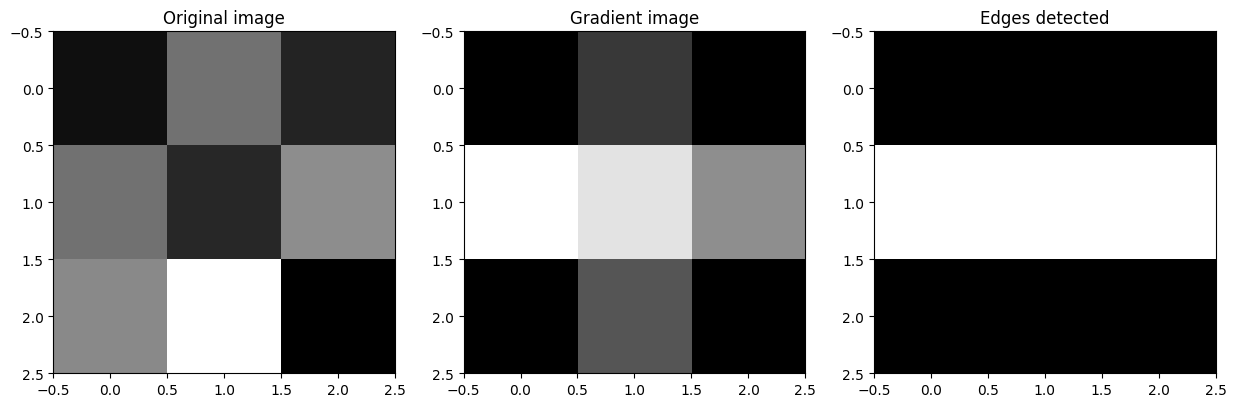

In [8]:
# Create an input image
image = np.array([[10,60,20],[60,22,74],[72,132,2]], dtype=np.uint8)

# Apply the Gaussian kernel
drog_kernel(image, w_kernel=1, sigma=1.2, threshold=100)

<font color='blue'>**Expected output:**  </font>

    (array([[ 0.03832673, -0.        , -0.03832673],
            [ 0.05423735, -0.        , -0.05423735],
            [ 0.03832673, -0.        , -0.03832673]]),
     array([[ 0.03832673,  0.05423735,  0.03832673],
            [-0.        , -0.        , -0.        ],
            [-0.03832673, -0.05423735, -0.03832673]]))

### <font color="blue"><b><i>Thinking about it (2)</i></b></font>

Now **try this method** and play with its interactive parameters in the next code cell. Then **answer the following questions**:

- What happens if a bigger kernel is used?
  
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Se elimina el ruido, esta vez de forma bastante más exitosa, la imagen queda mucho más clara.</i></p>
    
- What kind of errors appear and disappear whenever sigma is modified?
  
    <p style="margin: 4px 0px 0px 5px; color:blue"><i>Tanto si la aumentas como la disminuyes, hay bordes que no se detectan correctamente, y aparece mucho ruido.</i></p>   
    
- Why the gradient image have lower values than the one from the original image? *Tip: [image normalization](https://stackoverflow.com/questions/40645985/opencv-python-normalize-image/42164670)* 

    <p style="margin: 4px 0px 0px 5px; color:blue"><i>Yo creo, que es que al suavizar la imagen, los cambios de color no son tan abruptos y por tanto, el gradiente tiene valores más bajos, porque la "variación" de la "función" (imagen) es menor.</i></p>   
    
- Now that you have tried different techniques, in your opinion, which is the best one for this type of images?

    <p style="margin: 4px 0px 0px 5px; color:blue"><i>Yo diría, que aunque el Drog requiere de más coste computacional, es mejor. Priorizo en este caso la calidad, de nada sirve intentar detectar bordes si no los detectas bien por tanto me quedo con este, que me quita probkemas de ruido y da bordes mejor definidos</i></p>   

In [9]:
# Read the image
image = cv2.imread(images_path + 'medical_3.jpg', 0)

# Interact with the three input parameters
interactive(drog_kernel, image=fixed(image), w_kernel=(1,5,1), sigma=(0.4,5,0.5), threshold=(0,255,10), verbose=fixed(True))

interactive(children=(IntSlider(value=3, description='w_kernel', max=5, min=1), FloatSlider(value=2.4, descrip…

## Conclusion

Awesome! Now you have expertise in more applications of the convolution operator. In this notebook you:

- Learned basic operators for edge detection that perform a **discrete approximation of a gradient operator**.
- Learned **how to construct a DroG kernel** in an efficient way.
- Played a bit with them in the context of medical images, discovering some real and meaningful utilities.